En este notebook voy a terminar de adaptar el dataset para poder utilizarlo tanto con LSTM como con XGBoost u otro modelo.

In [1]:
from dotenv import load_dotenv
import os

# Cargar automáticamente las variables del archivo .env
load_dotenv()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_RAW = os.getenv('DATA_RAW')
DATA_PREPROCESSED = os.getenv('DATA_PROCESSED')
df_train = pd.read_csv(os.path.join('..',DATA_PREPROCESSED, "dataframe_train.csv"), sep=";")
df_test = pd.read_csv(os.path.join('..',DATA_PREPROCESSED, "dataframe_test.csv"), sep=";")

In [3]:
df = pd.read_csv(os.path.join('..',DATA_RAW, "dataframe_merged.csv"), sep=";")

In [4]:
df.iloc[:, 80:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sabor 79             775 non-null    float64
 1   Unnamed: 81          1 non-null      float64
 2   Total Cantidad       1065 non-null   object 
 3   dt_iso               1096 non-null   object 
 4   temp                 1096 non-null   float64
 5   dew_point            1096 non-null   float64
 6   feels_like           1096 non-null   float64
 7   temp_min             1096 non-null   float64
 8   temp_max             1096 non-null   float64
 9   pressure             1096 non-null   float64
 10  humidity             1096 non-null   float64
 11  wind_speed           1096 non-null   float64
 12  wind_deg             1096 non-null   float64
 13  wind_gust            865 non-null    float64
 14  rain_1h              393 non-null    float64
 15  clouds_all           1096 non-null   f

In [5]:
#Se comprobó previamente que ciertas columans no serán útiles:
# - dew_point
# - feels_like
# - temp_min
# - temp_max
# - weather_description
# - weather_main
# - Total Cantidad
# - Unnamed: 81
# - dt_iso
df.drop(
    ['dew_point',
'feels_like',
'temp_min',
'temp_max',
'weather_description',
'weather_main',
'Total Cantidad',
'Unnamed: 81',
'dt_iso'], axis= 1, inplace=True
)

In [6]:
y = df[[f'Sabor {i}' for i in range(1, 80)]]
X = df.drop([f'Sabor {i}' for i in range(1, 80)], axis = 1)

In [7]:
#Agregamos algunas columnas de fecha que podrían tener información sobre tendencias

X['Ajuste Fecha'] = pd.to_datetime(X['Ajuste Fecha'])
X['year'] = X['Ajuste Fecha'].dt.year
X['month'] = X['Ajuste Fecha'].dt.month
X['day'] = X['Ajuste Fecha'].dt.day
# Número de semana ISO (1-53) — lunes es el primer día de la semana
X['week'] = X['Ajuste Fecha'].dt.isocalendar().week      # tipo UInt32
X['week'] = X['week'].astype(int)                        # opcional, pasarlo a int


In [8]:
#Eliminar Fecha
X.drop('Ajuste Fecha', axis = 1, inplace=True)

In [9]:
X

,Dia Semana,temp,pressure,humidity,wind_speed,wind_deg,wind_gust,rain_1h,clouds_all,Estacion,EsFeriado,year,month,day,week
0,Lunes,25.950400,1002.680000,64.0,3.270,86.0,4.47,0.51,40.0,Verano,True,2022,1,1,52
1,Jueves,25.956667,1004.541667,80.0,2.570,60.0,NaN,0.51,0.5,Verano,False,2022,1,2,52
2,Jueves,28.290400,1006.760000,67.0,2.060,150.0,0.89,3.30,0.0,Verano,False,2022,1,3,1
3,Domingo,26.944615,1006.153846,69.0,4.955,198.5,2.68,1.90,0.0,Verano,False,2022,1,4,1
4,Martes,24.381250,1013.750000,53.5,4.885,125.0,3.13,NaN,0.0,Verano,False,2022,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,Domingo,22.339167,1013.083333,58.5,2.150,70.0,0.00,NaN,0.0,Verano,False,2024,12,27,52
1092,Lunes,24.437500,1016.666667,49.0,2.240,80.0,0.00,NaN,0.0,Verano,False,2024,12,28,52
1093,Martes,24.166250,1015.708333,52.5,4.470,100.0,0.00,NaN,0.0,Verano,False,2024,12,29,52
1094,Miércoles,25.622917,1011.958333,59.5,4.920,75.0,0.00,NaN,0.0,Verano,False,2024,12,30,1


# 2. Escalado de las variables

## División en Train Test

Con el fin de no producir fuga de datos, dividimos el conjunto antes de escalar.

In [10]:
y.shape

(1096, 79)

In [11]:
X_train = X.iloc[:X.shape[0]-14,:]
X_test = X.iloc[X.shape[0]-14:,:]

y_train = y.iloc[:y.shape[0]-14,:]
y_test = y.iloc[y.shape[0]-14:,:]

In [12]:
X_train.shape, X_test.shape

((1082, 15), (14, 15))

In [13]:
y_train.shape, y_test.shape

((1082, 79), (14, 79))

## Llenar valores nulos

In [14]:
X_train.isnull().sum()

Dia Semana      0
temp            0
pressure        0
humidity        0
wind_speed      0
wind_deg        0
wind_gust     231
rain_1h       693
clouds_all      0
Estacion        0
EsFeriado       0
year            0
month           0
day             0
week            0
dtype: int64

In [15]:
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace=True)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_25452\3055580040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(0, inplace = True)
C:\Users\IA-41\AppData\Local\Temp\ipykernel_25452\3055580040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(0, inplace=True)


In [16]:
y_train.shape

(1082, 79)

In [17]:
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace= True)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_25452\1137217824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.fillna(0, inplace=True)
C:\Users\IA-41\AppData\Local\Temp\ipykernel_25452\1137217824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.fillna(0, inplace= True)


## Escalado

In [18]:
from sklearn.preprocessing import RobustScaler

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

escalador = RobustScaler()
X_train_scaled = X_train.copy()
X_train_scaled[num_cols] = escalador.fit_transform(X_train[num_cols])

#Ahora con test
X_test_scaled = X_test.copy()
X_test_scaled[num_cols] = escalador.transform(X_test[num_cols])


In [19]:
X_train_scaled

,Dia Semana,temp,pressure,humidity,wind_speed,wind_deg,wind_gust,rain_1h,clouds_all,Estacion,EsFeriado,year,month,day,week
0,Lunes,0.746755,-1.451107,0.000000,-0.035149,-0.240602,1.000000,2.04,2.000,Verano,True,2022,1,1,52
1,Jueves,0.747422,-1.231087,0.820513,-0.363210,-0.501253,-0.667910,2.04,0.025,Verano,False,2022,1,2,52
2,Jueves,0.995799,-0.968915,0.153846,-0.602226,0.401003,-0.335821,13.20,0.000,Verano,False,2022,1,3,1
3,Domingo,0.852568,-1.040553,0.256410,0.754540,0.887218,0.332090,7.60,0.000,Verano,False,2022,1,4,1
4,Martes,0.579752,-0.142806,-0.538462,0.721734,0.150376,0.500000,0.00,0.000,Verano,False,2022,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,Domingo,0.610129,-0.787896,-0.615385,1.577036,0.701754,-0.667910,2.92,0.000,Primavera,False,2024,12,13,50
1078,Lunes,0.573544,-0.507208,-0.615385,0.363210,0.701754,-0.667910,0.00,0.000,Primavera,False,2024,12,14,50
1079,Martes,0.527336,-0.157579,-0.051282,0.363210,0.601504,-0.667910,0.00,0.000,Primavera,False,2024,12,15,50
1080,Miércoles,0.286895,0.088638,-0.564103,1.994142,0.701754,-0.667910,0.00,0.000,Primavera,False,2024,12,16,51


# Codificacion cíclica

In [21]:
import numpy as np

# --- 1) Día de la semana (0-6) → sen / cos -----------------------------
# Si aún está en texto, conviértelo primero:
if X_train_scaled['Dia Semana'].dtype == 'object':
    dia_map = {
        'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3,
        'Viernes': 4, 'Sábado': 5, 'Domingo': 6
    }
    X_train_scaled['Dia Semana'] = X_train_scaled['Dia Semana'].map(dia_map)

# Crear codificación cíclica
X_train_scaled['dia_sin'] = np.sin(2 * np.pi * X_train_scaled['Dia Semana'] / 7)
X_train_scaled['dia_cos'] = np.cos(2 * np.pi * X_train_scaled['Dia Semana'] / 7)

# --- 2) Mes (1-12) → sen / cos ----------------------------------------
# Asegúrate de que es entero 1-12
X_train_scaled['month'] = X_train_scaled['month'].astype(int)

X_train_scaled['month_sin'] = np.sin(2 * np.pi * (X_train_scaled['month'] - 1) / 12)
X_train_scaled['month_cos'] = np.cos(2 * np.pi * (X_train_scaled['month'] - 1) / 12)

# --- 3) (Opcional) Semana ISO (1-53) → sen / cos -----------------------
# Si quieres mantener la semanualidad cíclica también:
if 'week' in X_train_scaled.columns:
    X_train_scaled['week'] = X_train_scaled['week'].astype(int)
    X_train_scaled['week_sin'] = np.sin(2 * np.pi * (X_train_scaled['week'] - 1) / 53)
    X_train_scaled['week_cos'] = np.cos(2 * np.pi * (X_train_scaled['week'] - 1) / 53)

# --- 4) Estación (Verano-Otoño-Invierno-Primavera) → sen / cos --------
# 0: Verano, 1: Otoño, 2: Invierno, 3: Primavera
est_map = {'Verano': 0, 'Otoño': 1, 'Invierno': 2, 'Primavera': 3}
X_train_scaled['Estacion'] = X_train_scaled['Estacion'].map(est_map).astype(int)

X_train_scaled['est_sin'] = np.sin(2 * np.pi * X_train_scaled['Estacion'] / 4)
X_train_scaled['est_cos'] = np.cos(2 * np.pi * X_train_scaled['Estacion'] / 4)

# --- 5) Eliminar columnas originales -----------------------------------
X_train_scaled.drop(['Dia Semana', 'month', 'week'], axis=1, errors='ignore', inplace=True)


KeyError: 'Dia Semana'

In [22]:
X_train_scaled.head()

,temp,pressure,humidity,wind_speed,wind_deg,wind_gust,rain_1h,clouds_all,Estacion,EsFeriado,year,day,dia_sin,dia_cos,month_sin,month_cos,week_sin,week_cos,est_sin,est_cos
0,0.746755,-1.451107,0.000000,-0.035149,-0.240602,1.000000,2.04,2.000,0,True,2022,1,0.000000,1.000000,0.0,1.0,-0.234886,0.972023,0.0,1.0
1,0.747422,-1.231087,0.820513,-0.363210,-0.501253,-0.667910,2.04,0.025,0,False,2022,2,0.433884,-0.900969,0.0,1.0,-0.234886,0.972023,0.0,1.0
2,0.995799,-0.968915,0.153846,-0.602226,0.401003,-0.335821,13.20,0.000,0,False,2022,3,0.433884,-0.900969,0.0,1.0,0.000000,1.000000,0.0,1.0
3,0.852568,-1.040553,0.256410,0.754540,0.887218,0.332090,7.60,0.000,0,False,2022,4,-0.781831,0.623490,0.0,1.0,0.000000,1.000000,0.0,1.0
4,0.579752,-0.142806,-0.538462,0.721734,0.150376,0.500000,0.00,0.000,0,False,2022,5,0.781831,0.623490,0.0,1.0,0.000000,1.000000,0.0,1.0


In [23]:
import numpy as np

# ---------- 1. Día de la semana (0-6) ---------------
dia_map = {
    'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3,
    'Viernes': 4, 'Sábado': 5, 'Domingo': 6
}

# Si todavía está en texto:
if X_test_scaled['Dia Semana'].dtype == 'object':
    X_test_scaled['Dia Semana'] = X_test_scaled['Dia Semana'].map(dia_map)

# Pares sen/cos
X_test_scaled['dia_sin'] = np.sin(2 * np.pi * X_test_scaled['Dia Semana'] / 7)
X_test_scaled['dia_cos'] = np.cos(2 * np.pi * X_test_scaled['Dia Semana'] / 7)

# ---------- 2. Mes (1-12) ----------------------------
X_test_scaled['month'] = X_test_scaled['month'].astype(int)
X_test_scaled['month_sin'] = np.sin(2 * np.pi * (X_test_scaled['month'] - 1) / 12)
X_test_scaled['month_cos'] = np.cos(2 * np.pi * (X_test_scaled['month'] - 1) / 12)

# ---------- 3. Semana ISO (1-53) (si la tienes) ------
if 'week' in X_test_scaled.columns:
    X_test_scaled['week'] = X_test_scaled['week'].astype(int)
    X_test_scaled['week_sin'] = np.sin(2 * np.pi * (X_test_scaled['week'] - 1) / 53)
    X_test_scaled['week_cos'] = np.cos(2 * np.pi * (X_test_scaled['week'] - 1) / 53)


# --- 4) Estación (Verano-Otoño-Invierno-Primavera) → sen / cos --------
# 0: Verano, 1: Otoño, 2: Invierno, 3: Primavera
est_map = {'Verano': 0, 'Otoño': 1, 'Invierno': 2, 'Primavera': 3}
X_test_scaled['Estacion'] = X_test_scaled['Estacion'].map(est_map).astype(int)

X_test_scaled['est_sin'] = np.sin(2 * np.pi * X_test_scaled['Estacion'] / 4)
X_test_scaled['est_cos'] = np.cos(2 * np.pi * X_test_scaled['Estacion'] / 4)

# ---------- 5. Eliminar originales -------------------
X_test_scaled.drop(['Dia Semana', 'month', 'week'], axis=1, errors='ignore', inplace=True)



# (opcional) verifica resultado
X_test_scaled.head()

,temp,pressure,humidity,wind_speed,wind_deg,wind_gust,rain_1h,clouds_all,Estacion,EsFeriado,year,day,dia_sin,dia_cos,month_sin,month_cos,week_sin,week_cos,est_sin,est_cos
1082,0.421616,-0.310234,-0.205128,1.084944,-0.501253,-0.66791,1.00,0.00,3,False,2024,18,-0.433884,-0.900969,-0.5,0.866025,-0.348202,0.93742,-1.0,-1.836970e-16
1083,0.415896,-0.576149,-0.025641,-0.126538,0.701754,-0.66791,1.00,0.00,3,False,2024,19,-0.974928,-0.222521,-0.5,0.866025,-0.348202,0.93742,-1.0,-1.836970e-16
1084,0.700061,-0.891307,-0.179487,0.110135,0.401003,-0.66791,0.00,0.00,3,False,2024,20,-0.781831,0.623490,-0.5,0.866025,-0.348202,0.93742,-1.0,-1.836970e-16
1085,-0.097312,0.004924,0.769231,1.806678,0.300752,-0.66791,5.42,4.45,0,False,2024,21,0.000000,1.000000,-0.5,0.866025,-0.348202,0.93742,0.0,1.000000e+00
1086,0.046069,0.458752,-0.102564,-0.560047,-0.401003,-0.66791,0.00,0.00,0,False,2024,22,0.781831,0.623490,-0.5,0.866025,-0.348202,0.93742,0.0,1.000000e+00


In [24]:
y_train

,Sabor 1,Sabor 2,Sabor 3,Sabor 4,Sabor 5,Sabor 6,Sabor 7,Sabor 8,Sabor 9,Sabor 10,...,Sabor 70,Sabor 71,Sabor 72,Sabor 73,Sabor 74,Sabor 75,Sabor 76,Sabor 77,Sabor 78,Sabor 79
0,5.36,12.45,5.47,5.03,0.0,12.41,11.60,5.60,6.22,11.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
1,22.92,0.00,26.50,0.00,0.0,32.50,5.08,5.12,0.00,25.26,...,0.00,1.07,0.00,37.09,43.60,0.00,20.0,50.0,28.03,11.63
2,34.39,0.00,35.99,0.00,0.0,32.64,20.10,20.37,0.00,49.79,...,0.00,3.17,3.29,30.47,37.01,0.00,20.0,50.0,25.95,10.61
3,10.66,0.00,12.38,0.00,0.0,21.97,0.00,10.21,0.00,22.96,...,0.00,0.00,1.02,11.89,11.54,0.00,10.0,10.0,11.30,5.59
4,11.42,0.00,23.53,0.00,0.0,18.89,5.05,5.07,0.00,26.02,...,0.00,1.04,3.06,18.13,25.47,0.00,60.0,70.0,12.66,11.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,0.00,4.84,11.84,0.00,0.0,12.42,10.54,5.32,12.12,20.33,...,2.03,2.07,1.01,16.56,7.19,18.77,30.0,30.0,6.73,5.71
1078,23.08,5.06,34.18,0.00,0.0,17.66,5.24,0.00,7.08,26.19,...,0.00,6.23,4.11,37.18,30.72,5.88,30.0,40.0,24.72,9.92
1079,26.91,0.00,28.62,0.00,0.0,27.48,15.79,10.64,13.20,32.82,...,2.03,4.14,4.08,48.65,26.85,13.30,60.0,40.0,18.78,10.12
1080,4.65,9.79,23.68,0.00,0.0,18.78,26.27,10.66,6.60,36.94,...,3.04,4.13,1.03,22.72,31.95,24.86,30.0,30.0,18.86,11.05


In [25]:
y_train.fillna(0, inplace=True), y_test.fillna(0, inplace = True)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_25452\3910941107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.fillna(0, inplace=True), y_test.fillna(0, inplace = True)


(None, None)

In [26]:
y_train

,Sabor 1,Sabor 2,Sabor 3,Sabor 4,Sabor 5,Sabor 6,Sabor 7,Sabor 8,Sabor 9,Sabor 10,...,Sabor 70,Sabor 71,Sabor 72,Sabor 73,Sabor 74,Sabor 75,Sabor 76,Sabor 77,Sabor 78,Sabor 79
0,5.36,12.45,5.47,5.03,0.0,12.41,11.60,5.60,6.22,11.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
1,22.92,0.00,26.50,0.00,0.0,32.50,5.08,5.12,0.00,25.26,...,0.00,1.07,0.00,37.09,43.60,0.00,20.0,50.0,28.03,11.63
2,34.39,0.00,35.99,0.00,0.0,32.64,20.10,20.37,0.00,49.79,...,0.00,3.17,3.29,30.47,37.01,0.00,20.0,50.0,25.95,10.61
3,10.66,0.00,12.38,0.00,0.0,21.97,0.00,10.21,0.00,22.96,...,0.00,0.00,1.02,11.89,11.54,0.00,10.0,10.0,11.30,5.59
4,11.42,0.00,23.53,0.00,0.0,18.89,5.05,5.07,0.00,26.02,...,0.00,1.04,3.06,18.13,25.47,0.00,60.0,70.0,12.66,11.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,0.00,4.84,11.84,0.00,0.0,12.42,10.54,5.32,12.12,20.33,...,2.03,2.07,1.01,16.56,7.19,18.77,30.0,30.0,6.73,5.71
1078,23.08,5.06,34.18,0.00,0.0,17.66,5.24,0.00,7.08,26.19,...,0.00,6.23,4.11,37.18,30.72,5.88,30.0,40.0,24.72,9.92
1079,26.91,0.00,28.62,0.00,0.0,27.48,15.79,10.64,13.20,32.82,...,2.03,4.14,4.08,48.65,26.85,13.30,60.0,40.0,18.78,10.12
1080,4.65,9.79,23.68,0.00,0.0,18.78,26.27,10.66,6.60,36.94,...,3.04,4.13,1.03,22.72,31.95,24.86,30.0,30.0,18.86,11.05


# 3. LSTM

In [29]:
import numpy as np

def make_lstm_dataset(X_df, y_df, lookback=30, horizon=14, target_col='Sabor 1'):
    """
    Devuelve X, y listos para la red.
    X  -> (N, lookback, n_features)
    y  -> (N, horizon)
    """
    X_vals = X_df.values
    y_vals = y_df[target_col].values

    n_samples = len(X_df) - lookback - horizon + 1
    X_seq = np.zeros((n_samples, lookback, X_vals.shape[1]), dtype=np.float32)
    y_seq = np.zeros((n_samples, horizon),                 dtype=np.float32)

    for i in range(n_samples):
        start   = i
        end     = i + lookback
        fut_end = end + horizon
        X_seq[i] = X_vals[start:end]
        y_seq[i] = y_vals[end:fut_end]           # 14 pasos futuro

    return X_seq, y_seq

X_lstm, y_lstm = make_lstm_dataset(X_train_scaled, y_train,
                                   lookback=50, horizon=14,
                                   target_col='Sabor 1')

print(X_lstm.shape, y_lstm.shape)   # → (N, 30, 31)   (N, 14)


(1019, 50, 20) (1019, 14)


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

lookback   = 10
n_features = X_train_scaled.shape[1]
horizon    = 14

model = Sequential([
    Input(shape=(lookback, n_features)),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(horizon)          # 14 valores continuos, uno por día
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,302 (94.93 KB)

 Trainable params: 24,302 (94.93 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_lstm, y_lstm, test_size=0.1, shuffle=False)   # NO barajes series temporales

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[]   # EarlyStopping, ReduceLROnPlateau, etc.
)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - loss: 323.9884 - mae: 14.3015 - val_loss: 331.9738 - val_mae: 14.5290
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 310.4072 - mae: 13.8790 - val_loss: 293.4134 - val_mae: 13.4243
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 267.8620 - mae: 12.5276 - val_loss: 236.1810 - val_mae: 11.6209
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 222.1508 - mae: 10.9110 - val_loss: 180.2751 - val_mae: 9.8970
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 166.4920 - mae: 9.3771 - val_loss: 145.0016 - val_mae: 8.9071
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 139.7222 - mae: 8.7221 - val_loss: 130.2165 - val_mae: 8.7441
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 126.8908 - mae: 8.5485 - val_loss: 126.2019 - val_mae: 8.8037
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 127.5285 - mae: 8.6614 - val_loss: 125.5127 - val_mae: 8.8116
Epoch 9/50
29/29 ━━━━━━

## Predicción de los próximos 14 días

In [39]:
lookback   = 10
n_features = X_train_scaled.shape[1]

# Última ventana (30 días) → convertir a float32
last_window = (
    X_train_scaled.tail(lookback)        # 30 filas
                 .to_numpy(dtype='float32')
                 .reshape(1, lookback, n_features)
)

pred_14d = model.predict(last_window)[0]  # shape (14,)

print("Pronóstico 14 días Sabor 1:", pred_14d)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Pronóstico 14 días Sabor 1: [14.405352 14.418258 14.411905 14.486771 14.420132 14.397536 14.398892
 14.40283  14.288802 14.404865 14.436351 14.392079 14.361807 14.461815]


<Axes: xlabel='None', ylabel='Sabor 1'>

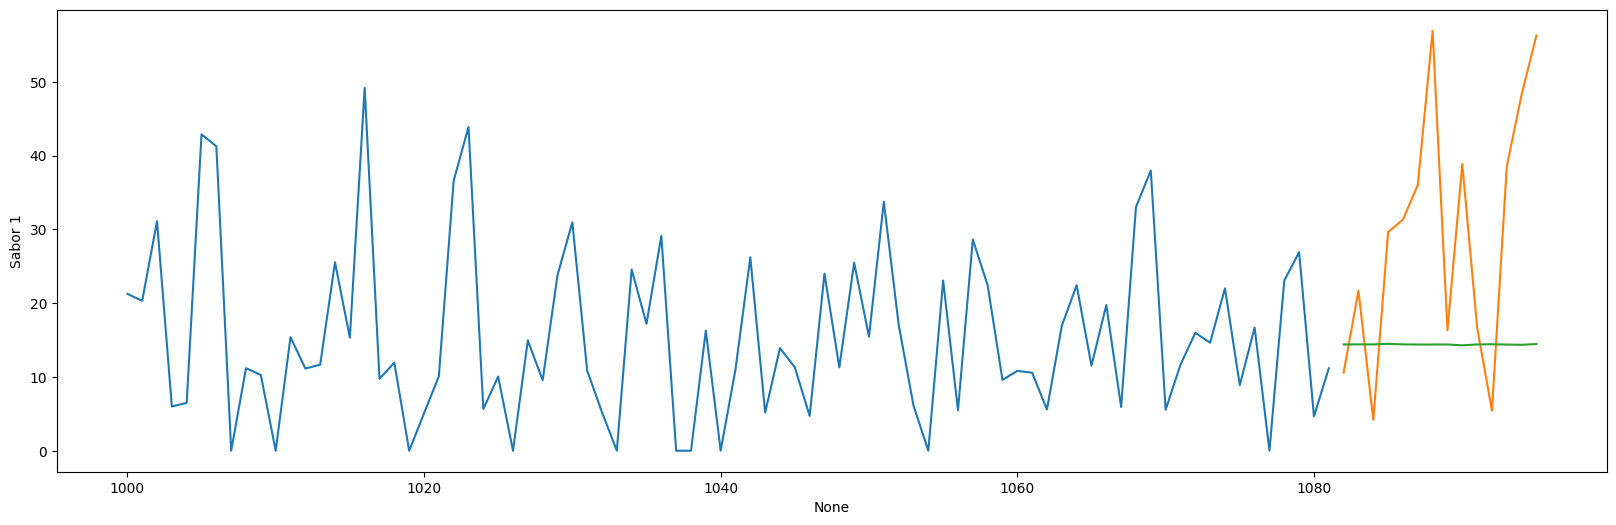

In [40]:
plt.figure(figsize=(20,6))
sns.lineplot(x = y_train.iloc[1000:,:].index, y = y_train.iloc[1000:,:]['Sabor 1'])
sns.lineplot(x = y_test.index, y = y_test['Sabor 1'])
sns.lineplot(x = y_test.index, y = pred_14d)

## ¿Por qué predice  un valor constante?

Parece ser que le falta información y se decanta por la predicción trivial.

In [44]:
y_scaler.fit_transform(y_train[['Sabor 1']])

array([[-0.83963887],
       [ 0.74581152],
       [ 1.78141037],
       ...,
       [ 1.10605907],
       [-0.90374307],
       [-0.31506787]])

In [41]:
from sklearn.preprocessing import RobustScaler
y_scaler = RobustScaler()
y_train_scaled = pd.DataFrame(
    y_scaler.fit_transform(y_train[['Sabor 1']]),
    columns=['Sabor 1'],#y_train.columns,
    index=y_train.index
)


In [42]:
import numpy as np

def make_lstm_dataset(X_df, y_df, lookback=30, horizon=14, target_col='Sabor 1'):
    """
    Devuelve X, y listos para la red.
    X  -> (N, lookback, n_features)
    y  -> (N, horizon)
    """
    X_vals = X_df.values
    y_vals = y_df[target_col].values

    n_samples = len(X_df) - lookback - horizon + 1
    X_seq = np.zeros((n_samples, lookback, X_vals.shape[1]), dtype=np.float32)
    y_seq = np.zeros((n_samples, horizon),                 dtype=np.float32)

    for i in range(n_samples):
        start   = i
        end     = i + lookback
        fut_end = end + horizon
        X_seq[i] = X_vals[start:end]
        y_seq[i] = y_vals[end:fut_end]           # 14 pasos futuro

    return X_seq, y_seq

X_lstm, y_lstm = make_lstm_dataset(X_train_scaled, y_train_scaled,
                                   lookback=30, horizon=14,
                                   target_col='Sabor 1')

#print(X_lstm.shape, y_lstm.shape)   # → (N, 30, 31)   (N, 14)

lookback   = 15
n_features = X_train_scaled.shape[1]
horizon    = 14

model = Sequential([
    Input(shape=(lookback, n_features)),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(horizon)          # 14 valores continuos, uno por día
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#model.summary()

X_tr, X_val, y_tr, y_val = train_test_split(
    X_lstm, y_lstm, test_size=0.2, shuffle=False)   # NO barajes series temporales

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[]   # EarlyStopping, ReduceLROnPlateau, etc.
)

lookback   = 30
n_features = X_train_scaled.shape[1]

# Última ventana (30 días) → convertir a float32
last_window = (
    X_train_scaled.tail(lookback)        # 30 filas
                 .to_numpy(dtype='float32')
                 .reshape(1, lookback, n_features)
)

pred_14d = model.predict(last_window)[0]  # shape (14,)

print("Pronóstico 14 días Sabor 1:", pred_14d)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.7020 - mae: 0.6296 - val_loss: 0.4491 - val_mae: 0.5348
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5516 - mae: 0.5662 - val_loss: 0.4416 - val_mae: 0.5355
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.5440 - mae: 0.5687 - val_loss: 0.4398 - val_mae: 0.5347
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.5512 - mae: 0.5654 - val_loss: 0.4398 - val_mae: 0.5360
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5488 - mae: 0.5638 - val_loss: 0.4390 - val_mae: 0.5354
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5365 - mae: 0.5578 - val_loss: 0.4385 - val_mae: 0.5352
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.5230 - mae: 0.5566 - val_loss: 0.4392 - val_mae: 0.5371
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.5376 - mae: 0.5631 - val_loss: 0.4384 - val_mae: 0.5358
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.516

In [53]:
pred_14d.reshape(-1,1)

array([[ 0.02299593],
       [ 0.01399431],
       [ 0.0181147 ],
       [ 0.02744263],
       [ 0.01885144],
       [ 0.04333639],
       [ 0.00313117],
       [ 0.03153735],
       [ 0.01437466],
       [ 0.02160592],
       [-0.01035319],
       [-0.00760014],
       [-0.01080847],
       [ 0.02875797]], dtype=float32)

In [43]:
pred_14d = y_scaler.inverse_transform(pred_14d.reshape(-1,1))

<Axes: xlabel='None', ylabel='Sabor 1'>

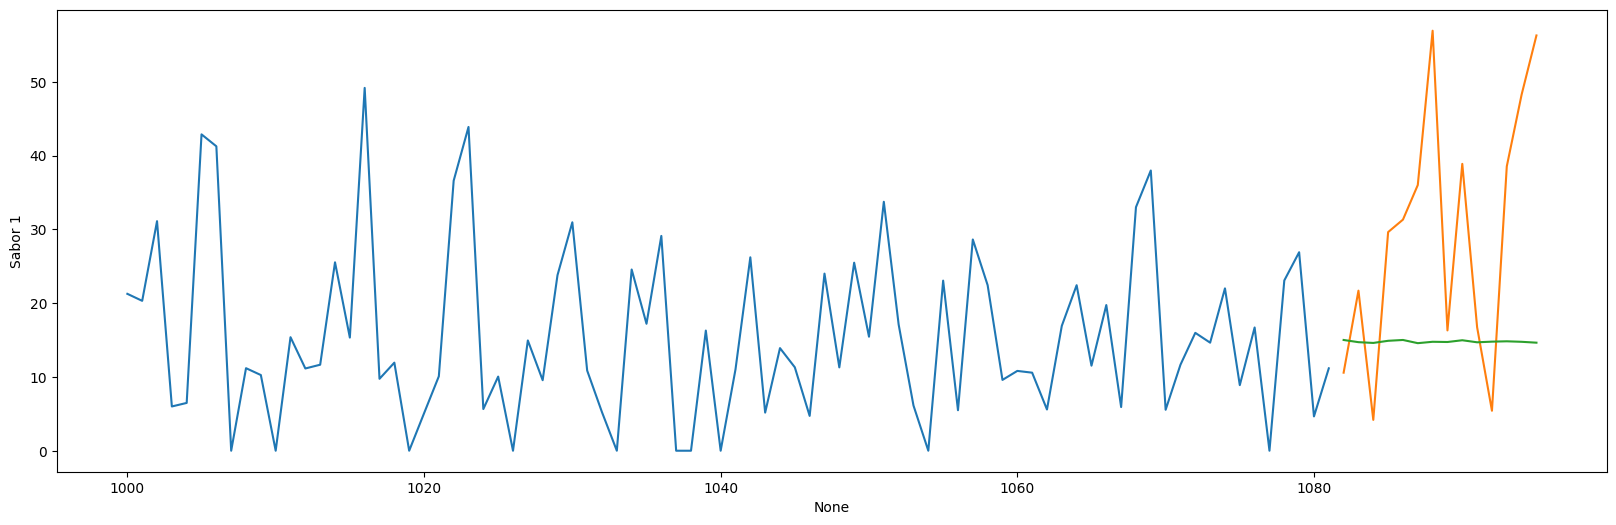

In [44]:
plt.figure(figsize=(20,6))
sns.lineplot(x = y_train.iloc[1000:,:].index, y = y_train.iloc[1000:,:]['Sabor 1'])
sns.lineplot(x = y_test.index, y = y_test['Sabor 1'])
sns.lineplot(x = y_test.index, y = pred_14d.flatten())

Se comprueba que el problema no era el escalado de la variable objetivo.

## Incluir Sabor 1 en las features de forma que la red pueda ver su pasado

In [67]:
X_train_scaled.head(3)

,temp,pressure,humidity,wind_speed,wind_deg,wind_gust,rain_1h,clouds_all,Estacion,EsFeriado,year,day,dia_sin,dia_cos,month_sin,month_cos,week_sin,week_cos,est_sin,est_cos
0,0.746755,-1.451107,0.000000,-0.035149,-0.240602,1.000000,2.04,2.000,0,True,2022,1,0.000000,1.000000,0.0,1.0,-0.234886,0.972023,0.0,1.0
1,0.747422,-1.231087,0.820513,-0.363210,-0.501253,-0.667910,2.04,0.025,0,False,2022,2,0.433884,-0.900969,0.0,1.0,-0.234886,0.972023,0.0,1.0
2,0.995799,-0.968915,0.153846,-0.602226,0.401003,-0.335821,13.20,0.000,0,False,2022,3,0.433884,-0.900969,0.0,1.0,0.000000,1.000000,0.0,1.0


In [68]:
y_train.head(3)

,Sabor 1,Sabor 2,Sabor 3,Sabor 4,Sabor 5,Sabor 6,Sabor 7,Sabor 8,Sabor 9,Sabor 10,...,Sabor 70,Sabor 71,Sabor 72,Sabor 73,Sabor 74,Sabor 75,Sabor 76,Sabor 77,Sabor 78,Sabor 79
0,5.36,12.45,5.47,5.03,0.0,12.41,11.60,5.60,6.22,11.21,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00
1,22.92,0.00,26.50,0.00,0.0,32.50,5.08,5.12,0.00,25.26,...,0.0,1.07,0.00,37.09,43.60,0.0,20.0,50.0,28.03,11.63
2,34.39,0.00,35.99,0.00,0.0,32.64,20.10,20.37,0.00,49.79,...,0.0,3.17,3.29,30.47,37.01,0.0,20.0,50.0,25.95,10.61


In [50]:
features = X_train_scaled.columns.tolist() + ['Sabor 1']
df_full = pd.concat([X_train_scaled, y_train['Sabor 1']], axis = 1)[features]

In [49]:
from sklearn.preprocessing import RobustScaler
y_scaler = RobustScaler()
y_train_scaled = pd.DataFrame(
    y_scaler.fit_transform(y_train[['Sabor 1']]),
    columns=['Sabor 1'],#y_train.columns,
    index=y_train.index
)

import numpy as np

def make_lstm_dataset(X_df, y_df, lookback=30, horizon=14, target_col='Sabor 1'):
    """
    Devuelve X, y listos para la red.
    X  -> (N, lookback, n_features)
    y  -> (N, horizon)
    """
    X_vals = X_df.values
    y_vals = y_df[target_col].values

    n_samples = len(X_df) - lookback - horizon + 1
    X_seq = np.zeros((n_samples, lookback, X_vals.shape[1]), dtype=np.float32)
    y_seq = np.zeros((n_samples, horizon),                 dtype=np.float32)

    for i in range(n_samples):
        start   = i
        end     = i + lookback
        fut_end = end + horizon
        X_seq[i] = X_vals[start:end]
        y_seq[i] = y_vals[end:fut_end]           # 14 pasos futuro

    return X_seq, y_seq

X_lstm, y_lstm = make_lstm_dataset(df_full, y_train_scaled,
                                   lookback=30, horizon=14,
                                   target_col='Sabor 1')

#print(X_lstm.shape, y_lstm.shape)   # → (N, 30, 31)   (N, 14)

lookback   = 15
n_features = df_full.shape[1]
horizon    = 14

#Modelo anterior
model = Sequential([
    Input(shape=(lookback, n_features)),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(14, activation='relu'),
    Dense(horizon)          # 14 valores continuos, uno por día
])

#Modelo con más capacidad
# model = Sequential([
#     Input(shape=(lookback, n_features)),
#     LSTM(128, return_sequences=True),
#     LSTM(64),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dense(horizon)
# ])



model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#model.summary()

X_tr, X_val, y_tr, y_val = train_test_split(
    X_lstm, y_lstm, test_size=0.2, shuffle=False)   # NO barajes series temporales

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[]   # EarlyStopping, ReduceLROnPlateau, etc.
)

lookback   = 15
n_features = df_full.shape[1]

# Última ventana (30 días) → convertir a float32
last_window = (
    df_full.tail(lookback)        # 30 filas
                 .to_numpy(dtype='float32')
                 .reshape(1, lookback, n_features)
)

pred_14d = model.predict(last_window)[0]  # shape (14,)

print("Pronóstico 14 días Sabor 1:", pred_14d)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.6142 - mae: 0.5840 - val_loss: 0.4556 - val_mae: 0.5304
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5646 - mae: 0.5594 - val_loss: 0.4463 - val_mae: 0.5292
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.5652 - mae: 0.5620 - val_loss: 0.4425 - val_mae: 0.5283
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5539 - mae: 0.5563 - val_loss: 0.4404 - val_mae: 0.5286
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.5602 - mae: 0.5606 - val_loss: 0.4393 - val_mae: 0.5288
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5332 - mae: 0.5504 - val_loss: 0.4381 - val_mae: 0.5298
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.5538 - mae: 0.5594 - val_loss: 0.4376 - val_mae: 0.5305
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.5072 - mae: 0.5455 - val_loss: 0.4372 - val_mae: 0.5313
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.527

<Axes: xlabel='None', ylabel='Sabor 1'>

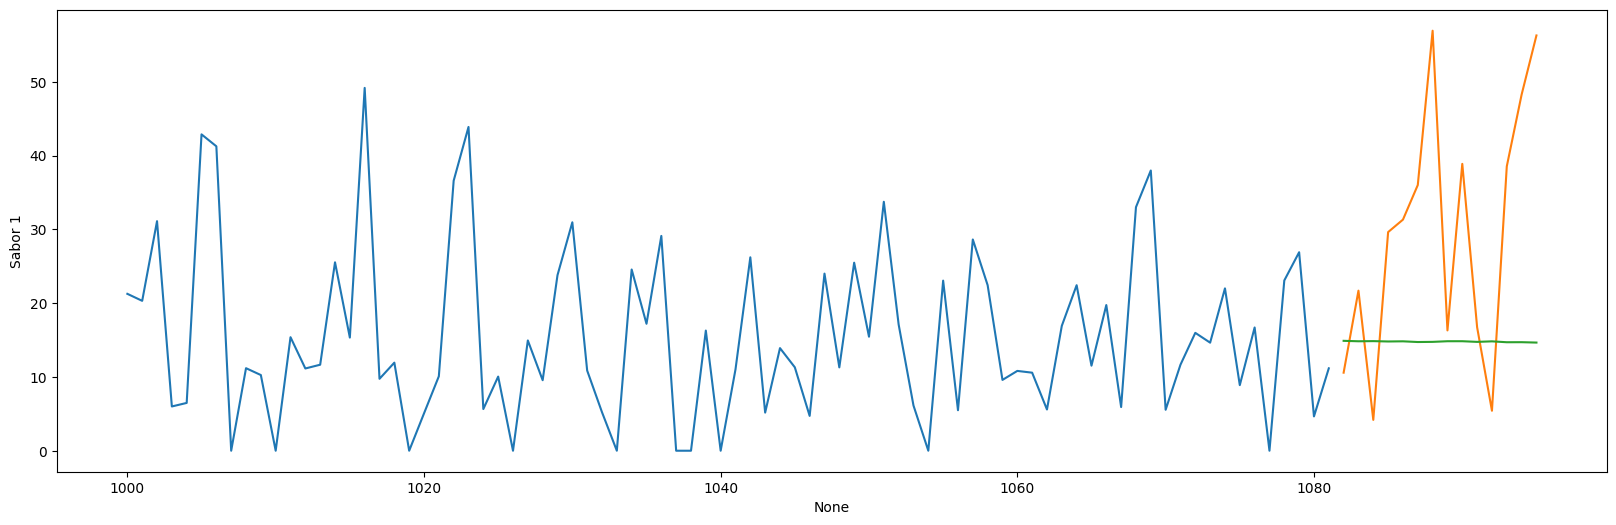

: 

In [ ]:
pred_14d = y_scaler.inverse_transform(pred_14d.reshape(-1,1))
plt.figure(figsize=(20,6))
sns.lineplot(x = y_train.iloc[1000:,:].index, y = y_train.iloc[1000:,:]['Sabor 1'])
sns.lineplot(x = y_test.index, y = y_test['Sabor 1'])
sns.lineplot(x = y_test.index, y = pred_14d.flatten())

## Prueba solo con Sabor 1, sin features

In [27]:
#Escalado de la var objetivo
from sklearn.preprocessing import RobustScaler
y_scaler = RobustScaler()
y_train_scaled = pd.DataFrame(
    y_scaler.fit_transform(y_train[['Sabor 1']]),
    columns=['Sabor 1'],
    index = y_train.index)



,Sabor 1,Sabor 2,Sabor 3,Sabor 4,Sabor 5,Sabor 6,Sabor 7,Sabor 8,Sabor 9,Sabor 10,...,Sabor 70,Sabor 71,Sabor 72,Sabor 73,Sabor 74,Sabor 75,Sabor 76,Sabor 77,Sabor 78,Sabor 79
0,5.36,12.45,5.47,5.03,0.0,12.41,11.60,5.60,6.22,11.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
1,22.92,0.00,26.50,0.00,0.0,32.50,5.08,5.12,0.00,25.26,...,0.00,1.07,0.00,37.09,43.60,0.00,20.0,50.0,28.03,11.63
2,34.39,0.00,35.99,0.00,0.0,32.64,20.10,20.37,0.00,49.79,...,0.00,3.17,3.29,30.47,37.01,0.00,20.0,50.0,25.95,10.61
3,10.66,0.00,12.38,0.00,0.0,21.97,0.00,10.21,0.00,22.96,...,0.00,0.00,1.02,11.89,11.54,0.00,10.0,10.0,11.30,5.59
4,11.42,0.00,23.53,0.00,0.0,18.89,5.05,5.07,0.00,26.02,...,0.00,1.04,3.06,18.13,25.47,0.00,60.0,70.0,12.66,11.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,0.00,4.84,11.84,0.00,0.0,12.42,10.54,5.32,12.12,20.33,...,2.03,2.07,1.01,16.56,7.19,18.77,30.0,30.0,6.73,5.71
1078,23.08,5.06,34.18,0.00,0.0,17.66,5.24,0.00,7.08,26.19,...,0.00,6.23,4.11,37.18,30.72,5.88,30.0,40.0,24.72,9.92
1079,26.91,0.00,28.62,0.00,0.0,27.48,15.79,10.64,13.20,32.82,...,2.03,4.14,4.08,48.65,26.85,13.30,60.0,40.0,18.78,10.12
1080,4.65,9.79,23.68,0.00,0.0,18.78,26.27,10.66,6.60,36.94,...,3.04,4.13,1.03,22.72,31.95,24.86,30.0,30.0,18.86,11.05


In [46]:
# ------------------------------------------------------------------
# 1. Escalamos SOLO la serie 'Sabor 1'
# ------------------------------------------------------------------
from sklearn.preprocessing import RobustScaler
import numpy as np, pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split

lookback = 90
horizon   = 14

serie = y_train[['Sabor 1']]                      # <- 1 sola columna
scaler = RobustScaler()
serie_scaled = pd.DataFrame(
    scaler.fit_transform(serie),                  # misma forma, pero escala robusta
    columns=['Sabor 1'],
    index=serie.index
)

# ------------------------------------------------------------------
# 2. Dataset listos para LSTM (un solo "feature")
# ------------------------------------------------------------------
def make_univar_dataset(serie_df, lookback=30, horizon=14, col='Sabor 1'):
    vals = serie_df[col].astype(np.float32).values          # (N,)
    n_samples = len(vals) - lookback - horizon + 1

    X = np.zeros((n_samples, lookback, 1), dtype=np.float32)
    y = np.zeros((n_samples, horizon),  dtype=np.float32)

    for i in range(n_samples):
        X[i, :, 0] = vals[i : i+lookback]                   # (lookback,)
        y[i,     :] = vals[i+lookback : i+lookback+horizon] # (horizon,)

    return X, y

X_lstm, y_lstm = make_univar_dataset(
    serie_scaled,
    lookback=lookback,
    horizon=horizon,
    col='Sabor 1'
)
print(X_lstm.shape, y_lstm.shape)          # --> (N, 15, 1)   (N, 14)

# ------------------------------------------------------------------
# 3. Modelo LSTM para serie univariante
# ------------------------------------------------------------------
model = Sequential([
    Input(shape=(lookback, 1)),            # <-- n_features = 1
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(28, activation='relu'),
    Dense(horizon)                         # 14 valores de salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

X_tr, X_val, y_tr, y_val = train_test_split(
    X_lstm, y_lstm, test_size=0.2, shuffle=False)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

# ------------------------------------------------------------------
# 4. Pronóstico (14 pasos) usando la última ventana
# ------------------------------------------------------------------
last_window = (
    serie_scaled.tail(lookback)            # (15 filas, 1 col)
               .to_numpy(dtype='float32')
               .reshape(1, lookback, 1)    # (1, 15, 1)
)

pred_14d_scaled = model.predict(last_window)[0]  # (14,)
pred_14d        = scaler.inverse_transform(
                     pred_14d_scaled.reshape(-1,1)
                 ).flatten()                     # des-escalamos

print("Pronóstico 14 días Sabor 1:", pred_14d)


(979, 90, 1) (979, 14)
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.5530 - mae: 0.5440 - val_loss: 0.4494 - val_mae: 0.5341
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.5349 - mae: 0.5547 - val_loss: 0.4435 - val_mae: 0.5355
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.5318 - mae: 0.5556 - val_loss: 0.4434 - val_mae: 0.5357
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.5110 - mae: 0.5488 - val_loss: 0.4435 - val_mae: 0.5387
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.5169 - mae: 0.5519 - val_loss: 0.4436 - val_mae: 0.5368
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.5140 - mae: 0.5523 - val_loss: 0.4454 - val_mae: 0.5371
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.5222 - mae: 0.5534 - val_loss: 0.4464 - val_mae: 0.5358
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.5122 - mae: 0.5519 - val_loss: 0.4499 - val_mae: 0.5354
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 

<Axes: xlabel='None', ylabel='Sabor 1'>

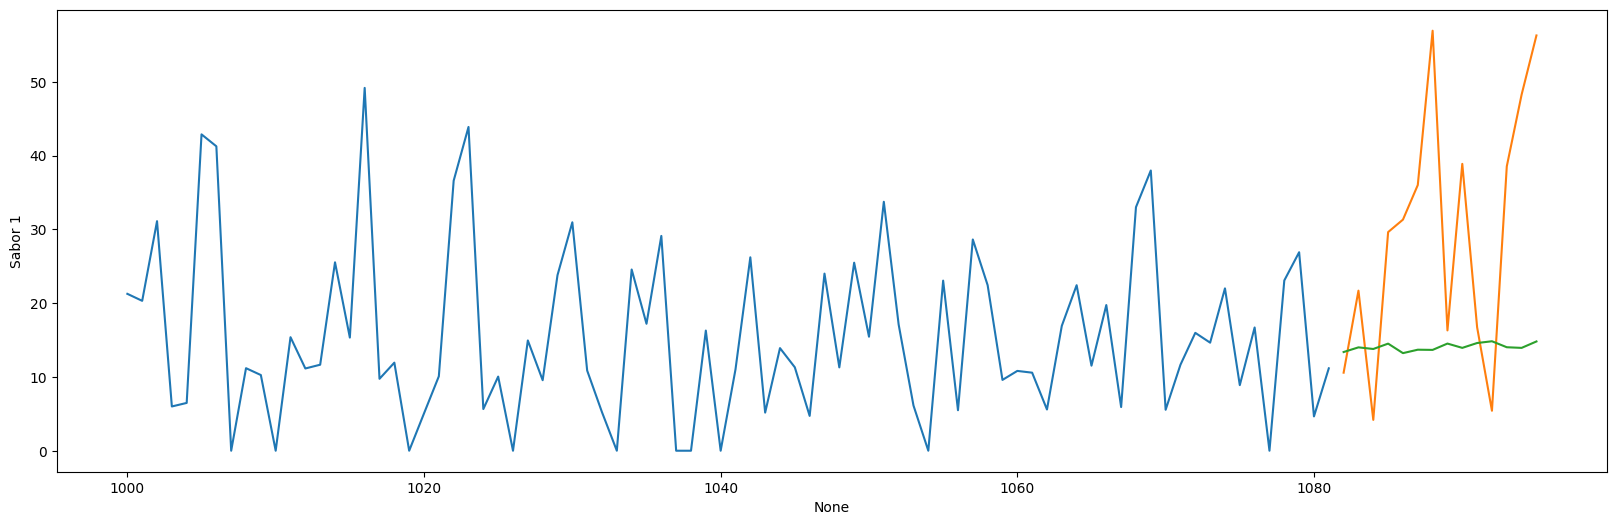

In [47]:

plt.figure(figsize=(20,6))
sns.lineplot(x = y_train.iloc[1000:,:].index, y = y_train.iloc[1000:,:]['Sabor 1'])
sns.lineplot(x = y_test.index, y = y_test['Sabor 1'])
sns.lineplot(x = y_test.index, y = pred_14d.flatten())

In [48]:
# 1. baseline tonto: "mañana = hoy"
y_pred_naive = y_val[:,0]                 # primer día del horizonte
mae_naive = np.abs(y_pred_naive - y_val[:,0]).mean()

# 2. baseline media histórica
media = y_tr.mean(axis=0)                 # media por horizonte
mae_media = np.abs(media - y_val).mean()

print("NAIVE MAE:", mae_naive, " | MEDIA MAE:", mae_media, " | LSTM MAE:", history.history['val_mae'][-1])


NAIVE MAE: 0.0  | MEDIA MAE: 0.54084074  | LSTM MAE: 0.5429652333259583


# 4. XGBoost

In [107]:
# ── 0. Imports ────────────────────────────────────────────────
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# ── 1. Configuración básica ──────────────────────────────────
serie      = df_full['Sabor 1'].astype('float32')   # ya tenés df_full
lookback   = 60                                     # nº lags como features
horizon    = 14                                     # nº pasos a predecir

# ── 2. Generar features (lags + rolling stats opcionales) ────
def make_supervised(s, lags=60, horiz=14):
    df = pd.DataFrame({'t': s})
    # lags 1…lags
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['t'].shift(i)
    # rolling stats (ejemplo: media y desv. 7 días)
    df['roll7_mean'] = df['t'].rolling(7).mean().shift(1)
    df['roll7_std']  = df['t'].rolling(7).std().shift(1)
    # objetivos t+1 … t+horiz
    for h in range(1, horiz+1):
        df[f't_plus_{h}'] = df['t'].shift(-h)
    return df.dropna()

data = make_supervised(serie, lags=lookback, horiz=horizon)

X = data.filter(like='lag_').join(data[['roll7_mean', 'roll7_std']])
y = data[[f't_plus_{h}' for h in range(1, horizon+1)]]

# ── 3. Split temporal (sin barajar) ───────────────────────────
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False)

# ── 4. Modelo XGBoost ────────────────────────────────────────
xgb_params = dict(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

base_model = XGBRegressor(**xgb_params)
model      = MultiOutputRegressor(base_model, n_jobs=-1)

model.fit(X_train, y_train)

# ── 5. Evaluación rápida ─────────────────────────────────────
pred_val = model.predict(X_val)
mae      = mean_absolute_error(y_val, pred_val)
print(f"MAE validación (14 días promedio): {mae:0.3f}")

# ── 6. Pronóstico futuro ─────────────────────────────────────
last_row = X.tail(1)                     # features hasta hoy
forecast_scaled = model.predict(last_row)[0]  # array(14,)
# si habías escalado antes, des-escala aquí.  (robust, min-max, etc.)
print("Pronóstico próximos 14 días:", forecast_scaled)


MAE validación (14 días promedio): 7.198
Pronóstico próximos 14 días: [12.221655 14.054124 13.35375  12.025617 15.529961 19.699438 10.465536
 15.752734 12.89584  15.369161 22.242064 17.535786 17.405796 11.572904]


In [108]:
produccionHasta60diasAntes = X.tail(1).values[0]
produccion14diasDespues = y.tail(1).values[0]
produccionPredicha = forecast_scaled

<Axes: >

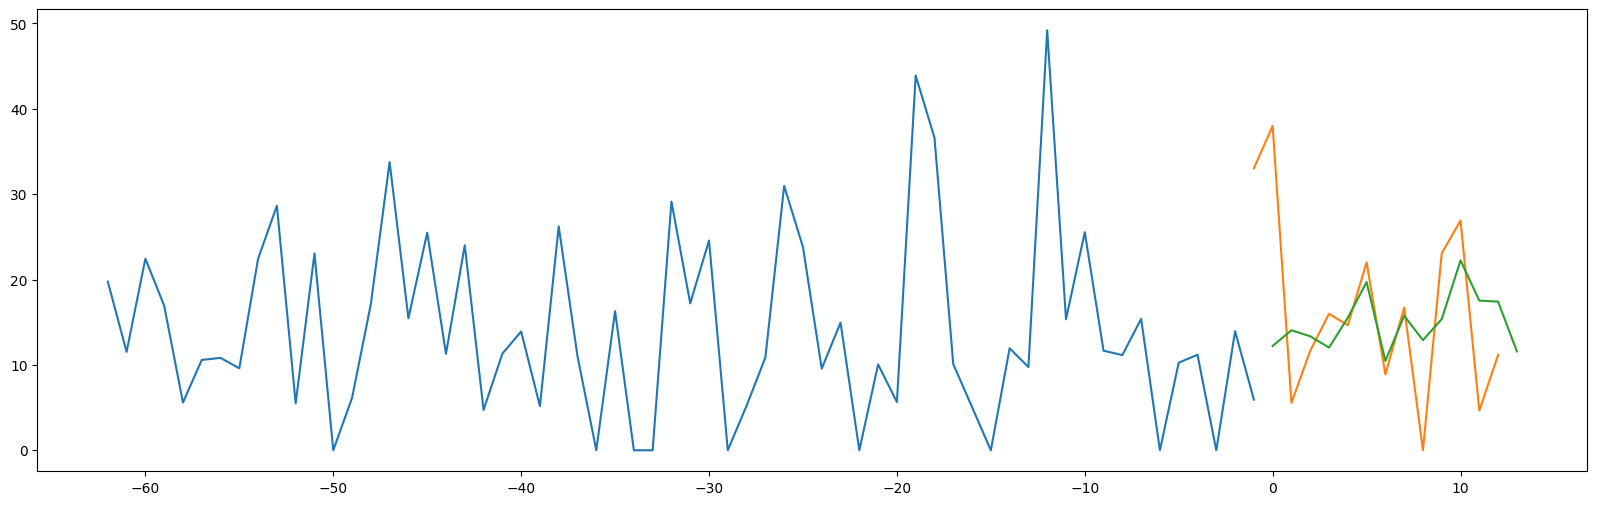

In [112]:
plt.figure(figsize=(20,6))
sns.lineplot(x =range(-len(produccionHasta60diasAntes), 0), y = produccionHasta60diasAntes)
sns.lineplot(x = range(-1, len(produccion14diasDespues)-1), y = produccion14diasDespues)
sns.lineplot(x = range(14), y = forecast_scaled)

In [ ]:
import joblib, os, pathlib

# Asegura que la carpeta exista
pathlib.Path("../models").mkdir(parents=True, exist_ok=True)

# ── guardar ───────────────────────────────────────────
joblib.dump(model, "../models/xgb_multioutput.joblib")

# ── cargar ────────────────────────────────────────────
#model = joblib.load("../models/xgb_multioutput.joblib")


['../models/xgb_multioutput.joblib']

: 